### User Engagement Analysis
- User Engagement Analysis focuses on tracking user activities on database sessions to appreciate user engagement for overall applications and per application. The engagement metrics to be used are:
    - Sessions frequency
    - Duration of the session
    - Session total traffic (download and upload in bytes)

In [1]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
# import script module 
from scripts.user_engagement import *

In [3]:
# Load the data
df = pd.read_csv('../data/cleaned_telecom_data.csv')

In [4]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,2019-04-04 12:01:00,770.0,2019-04-25 14:35:00,662.0,244912.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,2019-04-09 13:04:00,235.0,2019-04-25 08:15:00,606.0,244912.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,2019-04-09 17:42:00,1.0,2019-04-25 11:58:00,652.0,244912.0,2.082008e+14,3.373456e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,2019-04-10 00:31:00,486.0,2019-04-25 07:36:00,171.0,244912.0,2.082014e+14,3.373456e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,2019-04-12 20:10:00,565.0,2019-04-25 10:40:00,954.0,244912.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 150001 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150001 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150001 non-null  float64
 5   Dur. (ms)                                 150001 non-null  float64
 6   IMSI                                      150001 non-null  float64
 7   MSISDN/Number                             150001 non-null  float64
 8   IMEI                                      150001 non-null  float64
 9   Last Location Name                        150001 non-null  object 
 10  Avg RTT DL (ms)     

In [6]:
df.describe()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,1.500010e+05,150001.000000,150001.000000,150001.000000,1.500010e+05,1.500010e+05,1.500010e+05,150001.000000,150001.000000,150001.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05
mean,1.013887e+19,499.188200,498.800880,99572.128983,2.082015e+14,3.366999e+10,4.847455e+13,72.862020,12.037797,11112.355328,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112120e+07,4.546434e+08
std,2.883600e+18,288.610872,288.096693,59084.184127,3.925668e+08,3.532589e+07,2.237359e+13,51.361714,11.040917,17189.349903,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.126923e+07,2.441421e+08
min,6.917538e+18,0.000000,0.000000,7142.000000,2.082008e+14,3.360168e+10,4.400152e+11,0.000000,0.000000,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,9.503716e+06,7.114041e+06
25%,7.349883e+18,250.000000,251.000000,57442.000000,2.082014e+14,3.365151e+10,3.546261e+13,35.000000,3.000000,43.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322203e+07,2.431072e+08
50%,7.349883e+18,499.000000,500.000000,86399.000000,2.082015e+14,3.366380e+10,3.572241e+13,54.000000,7.000000,63.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114324e+07,4.558409e+08
75%,1.304243e+19,749.000000,750.000000,132430.000000,2.082018e+14,3.368473e+10,8.611970e+13,109.795706,17.662883,19710.000000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657051e+08
max,1.318654e+19,999.000000,999.000000,244912.000000,2.082023e+14,3.373456e+10,9.900120e+13,221.989265,39.657207,49210.500000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.275255e+07,9.029696e+08


In [7]:
print(df.isnull().sum())

Bearer Id                                   0
Start                                       1
Start ms                                    0
End                                         1
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

### Aggregate  'Bearer Id' (session frequency), Dur. (ms) (total duration) and session total traffic(Total DL (Bytes) + Total UL (Bytes)) metrics per customer id (MSISDN) and report the top 10 customers per engagement metric

In [8]:
# aggregrate mmetrics per customer 
aggregated_data, top_10_customers = aggregate_metrics_per_customer(df)

Top 10 customers by number of Sessions

In [9]:
print("Top 10 customers by number of sessions:")
print(top_10_customers['Sessions'])

Top 10 customers by number of sessions:
             MSISDN  Sessions      Duration    DL Traffic    UL Traffic  \
90037  3.373456e+10     24383  2.433741e+09  1.102166e+13  1.003051e+12   
0      3.360168e+10       359  3.411218e+07  1.682756e+11  1.467565e+10   
13262  3.362632e+10        18  4.004601e+06  7.301517e+09  6.696507e+08   
6173   3.361489e+10        17  3.897579e+06  8.156743e+09  6.894830e+08   
12916  3.362578e+10        17  4.135260e+06  7.770043e+09  7.295774e+08   
36788  3.365973e+10        16  3.490608e+06  7.081602e+09  6.242603e+08   
76099  3.367588e+10        15  3.330261e+06  7.309542e+09  5.815688e+08   
64854  3.366716e+10        13  3.111859e+06  5.052068e+09  5.663264e+08   
402    3.360313e+10        12  2.853379e+06  4.540607e+09  4.355876e+08   
1015   3.360452e+10        12  2.778163e+06  5.096079e+09  3.917759e+08   

       Total Traffic  
90037   1.202471e+13  
0       1.829512e+11  
13262   7.971167e+09  
6173    8.846226e+09  
12916   8.499621e+0

Top 10 customers by total duration

In [10]:
print("\nTop 10 customers by total duration:")
print(top_10_customers['Duration'])


Top 10 customers by total duration:
             MSISDN  Sessions      Duration    DL Traffic    UL Traffic  \
90037  3.373456e+10     24383  2.433741e+09  1.102166e+13  1.003051e+12   
0      3.360168e+10       359  3.411218e+07  1.682756e+11  1.467565e+10   
12916  3.362578e+10        17  4.135260e+06  7.770043e+09  7.295774e+08   
13262  3.362632e+10        18  4.004601e+06  7.301517e+09  6.696507e+08   
6173   3.361489e+10        17  3.897579e+06  8.156743e+09  6.894830e+08   
36788  3.365973e+10        16  3.490608e+06  7.081602e+09  6.242603e+08   
76099  3.367588e+10        15  3.330261e+06  7.309542e+09  5.815688e+08   
64854  3.366716e+10        13  3.111859e+06  5.052068e+09  5.663264e+08   
402    3.360313e+10        12  2.853379e+06  4.540607e+09  4.355876e+08   
13730  3.362708e+10        12  2.780470e+06  5.309479e+09  4.452519e+08   

       Total Traffic  
90037   1.202471e+13  
0       1.829512e+11  
12916   8.499621e+09  
13262   7.971167e+09  
6173    8.846226e+09  

Top 10 customers by total traffic

In [11]:
print("\nTop 10 customers by total traffic:")
print(top_10_customers['Total Traffic'])


Top 10 customers by total traffic:
             MSISDN  Sessions      Duration    DL Traffic    UL Traffic  \
90037  3.373456e+10     24383  2.433741e+09  1.102166e+13  1.003051e+12   
0      3.360168e+10       359  3.411218e+07  1.682756e+11  1.467565e+10   
6173   3.361489e+10        17  3.897579e+06  8.156743e+09  6.894830e+08   
12916  3.362578e+10        17  4.135260e+06  7.770043e+09  7.295774e+08   
13262  3.362632e+10        18  4.004601e+06  7.301517e+09  6.696507e+08   
76099  3.367588e+10        15  3.330261e+06  7.309542e+09  5.815688e+08   
36788  3.365973e+10        16  3.490608e+06  7.081602e+09  6.242603e+08   
62764  3.366646e+10        11  2.595320e+06  6.903440e+09  4.050610e+08   
56977  3.366471e+10        11  2.602195e+06  6.400774e+09  4.715731e+08   
86191  3.369879e+10        11  2.637433e+06  6.010556e+09  5.303431e+08   

       Total Traffic  
90037   1.202471e+13  
0       1.829512e+11  
6173    8.846226e+09  
12916   8.499621e+09  
13262   7.971167e+09  


### Normalize each engagement metric and run k-means (k=3) to classify customers

In [12]:
normalized_data, kmeans = normalize_and_cluster(aggregated_data)

In [13]:
kmeans

KMeans(n_clusters=3, random_state=42)

In [14]:
normalized_data

,Sessions,Duration,Total Traffic,Cluster
0,4.397032,4.184654,4.544161,2
1,-0.008195,-0.015703,-0.012134,0
2,-0.008195,-0.013980,0.001863,0
3,0.004110,-0.005620,0.018998,0
4,-0.008195,0.001250,-0.016158,0
...,...,...,...,...
90033,-0.008195,0.000713,0.000037,0
90034,-0.008195,-0.019278,-0.006026,0
90035,-0.008195,-0.012308,-0.008605,0
90036,-0.008195,0.005957,-0.010758,0


### Compute the minimum, maximum, average & total non-normalized metrics for each cluster. 

In [15]:
# Compute cluster statistics
cluster_stats = compute_cluster_stats(aggregated_data, normalized_data)
print("\nCluster statistics:")
cluster_stats


Cluster statistics:


Sessions                                  Duration                \
             min    max         mean     sum           min           max   
Cluster                                                                    
0              1     18      1.39121  125259  7.146000e+03  4.135260e+06   
1          24383  24383  24383.00000   24383  2.433741e+09  2.433741e+09   
2            359    359    359.00000     359  3.411218e+07  3.411218e+07   

                                    Total Traffic                              \
                 mean           sum           min           max          mean   
Cluster                                                                         
0        1.384787e+05  1.246807e+10  3.324901e+07  8.846226e+09  6.903631e+08   
1        2.433741e+09  2.433741e+09  1.202471e+13  1.202471e+13  1.202471e+13   
2        3.411218e+07  3.411218e+07  1.829512e+11  1.829512e+11  1.829512e+11   

                       
                  sum  
Cluster                
0        6.215753e+13  
1        1.202471e+13  
2        1.829512e+11

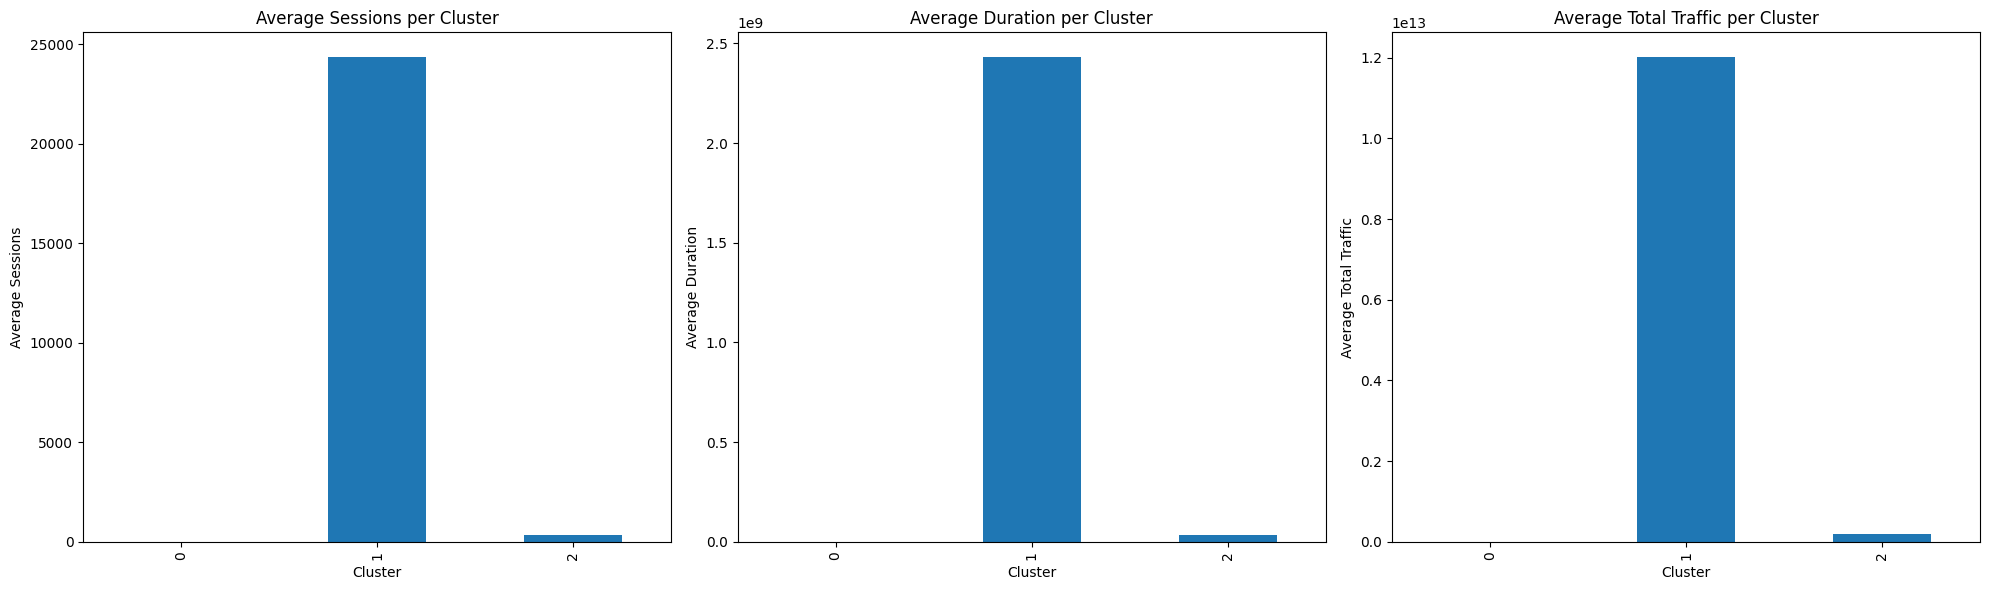

In [16]:
# Visualize cluster statistics
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
metrics = ['Sessions', 'Duration', 'Total Traffic']

for i, metric in enumerate(metrics):
    cluster_stats[metric]['mean'].plot(kind='bar', ax=axes[i], title=f'Average {metric} per Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(f'Average {metric}')

plt.tight_layout()
plt.show()

### Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [17]:
# Aggregate user total traffic per application and derive top 10 most engaged users per application
top_10_per_app = aggregate_traffic_per_app(df)

for app, top_10 in top_10_per_app.items():
    print(f"\nTop 10 users for {app}:")
    print(top_10)


Top 10 users for Social Media:
         MSISDN  Social Media Total Traffic
0  3.373456e+10                4.468294e+10
1  3.360168e+10                6.654877e+08
2  3.362632e+10                4.337478e+07
3  3.365973e+10                3.541236e+07
4  3.361489e+10                2.829454e+07
5  3.362578e+10                2.713550e+07
6  3.366716e+10                2.424785e+07
7  3.366907e+10                2.380083e+07
8  3.360313e+10                2.307782e+07
9  3.365849e+10                2.300007e+07

Top 10 users for Youtube:
         MSISDN  Youtube Total Traffic
0  3.373456e+10           5.540751e+11
1  3.360168e+10           7.948124e+09
2  3.362578e+10           4.529588e+08
3  3.361489e+10           3.943702e+08
4  3.362632e+10           3.744830e+08
5  3.367588e+10           3.174106e+08
6  3.366716e+10           3.152313e+08
7  3.362708e+10           3.087908e+08
8  3.369879e+10           3.026620e+08
9  3.360313e+10           2.840901e+08

Top 10 users for Netflix:
 

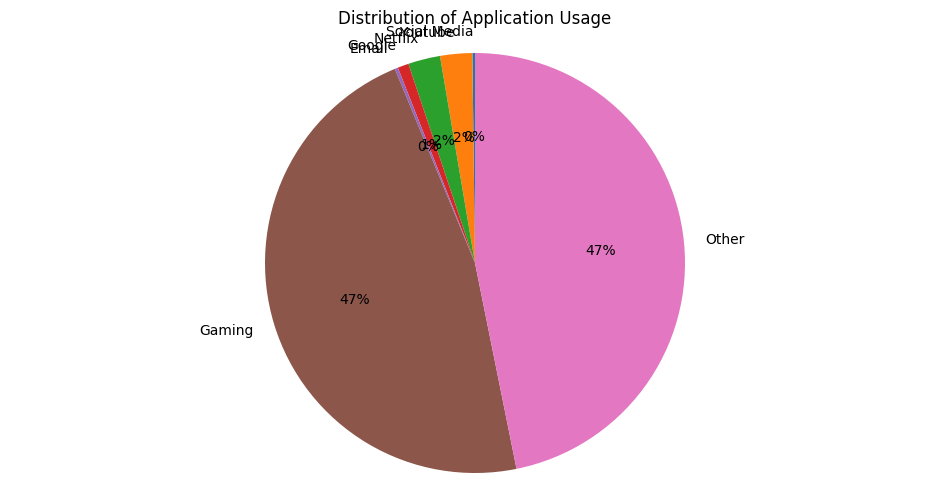

In [18]:
# Visualize application usage distribution
apps = ['Social Media', 'Youtube', 'Netflix', 'Google', 'Email', 'Gaming', 'Other']
app_usage = [df[f'{app} DL (Bytes)'].sum() + df[f'{app} UL (Bytes)'].sum() for app in apps]

plt.figure(figsize=(12, 6))
plt.pie(app_usage, labels=apps, autopct='%1.f%%', startangle=90)
plt.title('Distribution of Application Usage')
plt.axis('equal')
plt.show()

### plot for Top 3 most used applications 

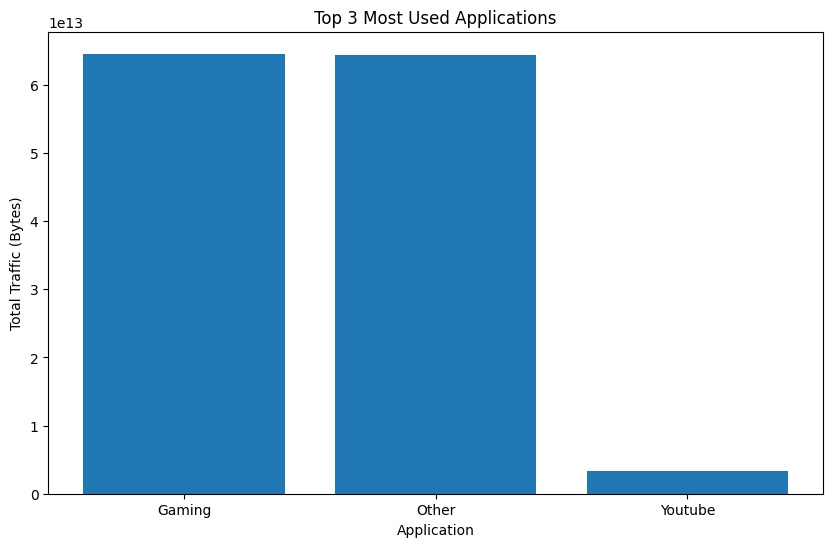

In [19]:
# Plot the top 3 most used applications
top_apps_fig = plot_top_apps(df)
plt.show()

### Using k-means clustering algorithm, group users in k engagement clusters and determine the optimized value of k using the elbow method

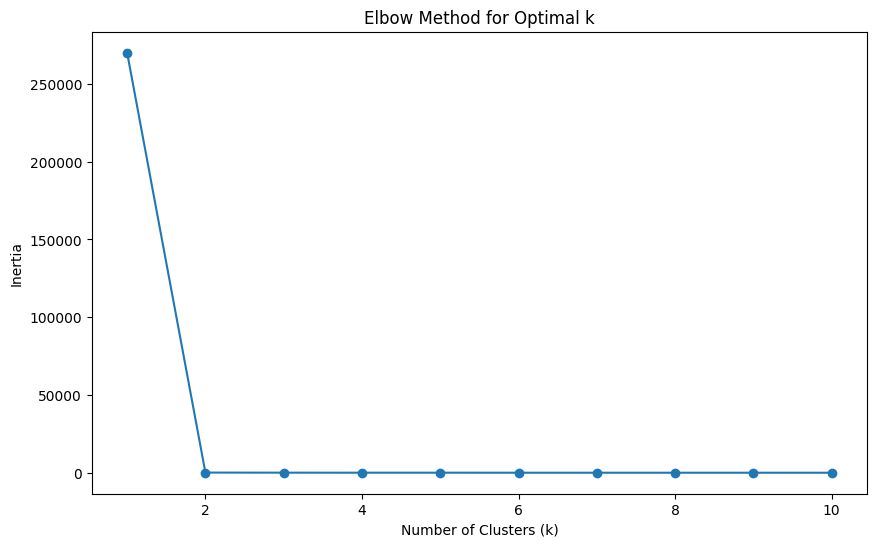

In [20]:
elbow_fig = elbow_method(aggregated_data)
plt.show()

### Analysis of engagement patterns over time

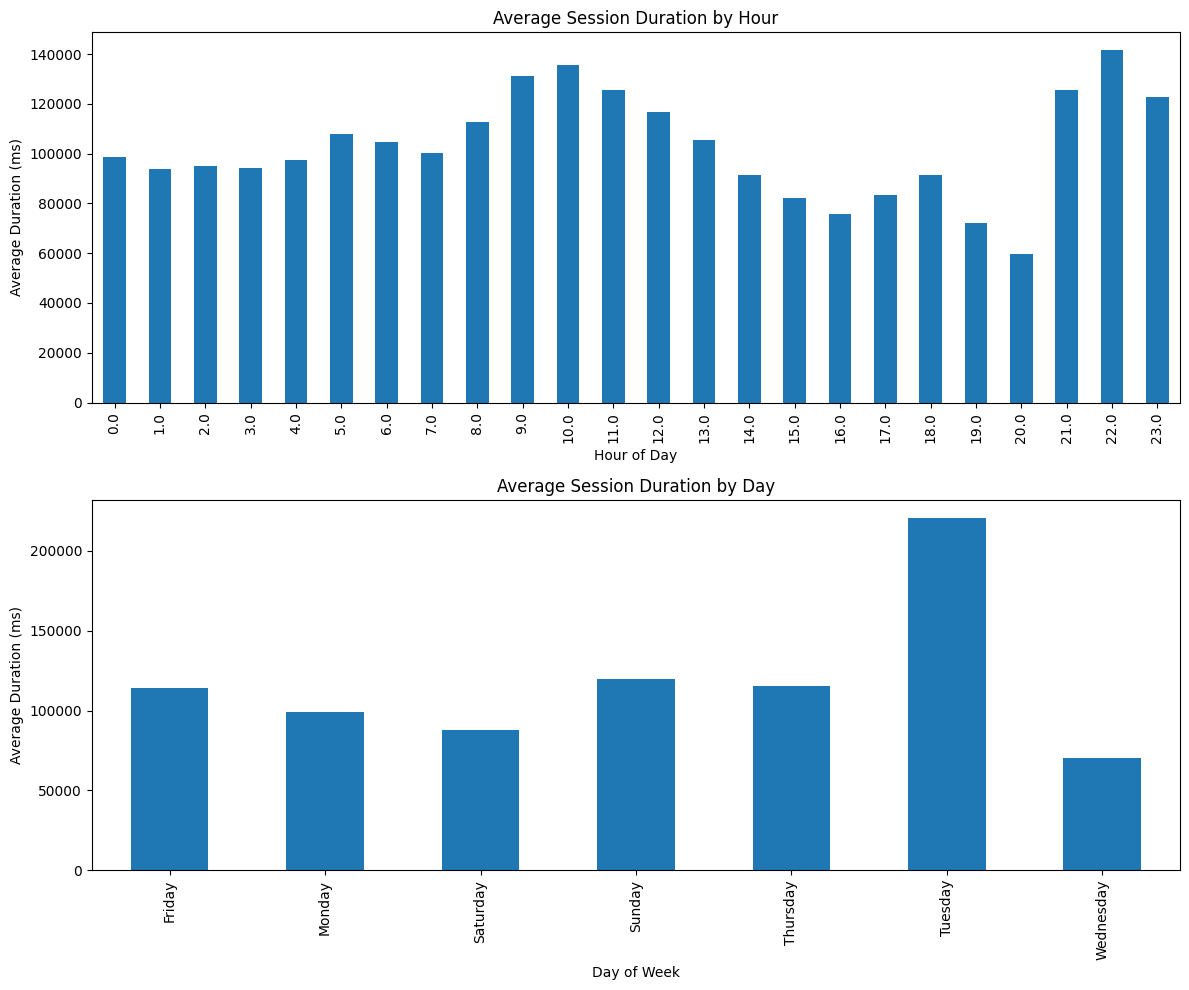

In [21]:
# Analyze engagement patterns over time
df['Start'] = pd.to_datetime(df['Start'])
df['Hour'] = df['Start'].dt.hour
df['Day'] = df['Start'].dt.day_name()

hourly_engagement = df.groupby('Hour')['Dur. (ms)'].mean()
daily_engagement = df.groupby('Day')['Dur. (ms)'].mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
hourly_engagement.plot(kind='bar', ax=ax1)
ax1.set_title('Average Session Duration by Hour')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Duration (ms)')

daily_engagement.plot(kind='bar', ax=ax2)
ax2.set_title('Average Session Duration by Day')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Average Duration (ms)')

plt.tight_layout()
plt.show()